# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

C:\Users\hp\anaconda3\envs\sdv_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,1,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
# from utils import get_mnist_data
# train, test = get_mnist_data(train_transforms, test_transforms)
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.05
from model import Model_4


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_4().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             576
              ReLU-6            [-1, 8, 32, 32]               0
       BatchNorm2d-7            [-1, 8, 32, 32]              16
           Dropout-8            [-1, 8, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             576
             ReLU-10            [-1, 8, 32, 32]               0
      BatchNorm2d-11            [-1, 8, 32, 32]              16
          Dropout-12            [-1, 8, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]             128
        MaxPool2d-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Model_4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.3768607378005981 Batch_id=390 Accuracy=40.54: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.75it/s]



Test set: Average loss: 1.4024, Accuracy: 4936/10000 (49.36%)

EPOCH: 1


Loss=1.155226469039917 Batch_id=390 Accuracy=52.98: 100%|████████████████████████████| 391/391 [00:14<00:00, 26.86it/s]



Test set: Average loss: 1.3610, Accuracy: 5227/10000 (52.27%)

EPOCH: 2


Loss=1.224179983139038 Batch_id=390 Accuracy=58.32: 100%|████████████████████████████| 391/391 [00:14<00:00, 26.41it/s]



Test set: Average loss: 1.1569, Accuracy: 5828/10000 (58.28%)

EPOCH: 3


Loss=1.138765811920166 Batch_id=390 Accuracy=61.37: 100%|████████████████████████████| 391/391 [00:15<00:00, 25.95it/s]



Test set: Average loss: 1.0288, Accuracy: 6353/10000 (63.53%)

EPOCH: 4


Loss=0.9222905039787292 Batch_id=390 Accuracy=63.68: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.36it/s]



Test set: Average loss: 0.9840, Accuracy: 6511/10000 (65.11%)

EPOCH: 5


Loss=0.818494439125061 Batch_id=390 Accuracy=67.92: 100%|████████████████████████████| 391/391 [00:14<00:00, 26.64it/s]



Test set: Average loss: 0.9014, Accuracy: 6755/10000 (67.55%)

EPOCH: 6


Loss=1.0478808879852295 Batch_id=390 Accuracy=68.75: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.90it/s]



Test set: Average loss: 0.8775, Accuracy: 6871/10000 (68.71%)

EPOCH: 7


Loss=0.9035374522209167 Batch_id=390 Accuracy=69.57: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.57it/s]



Test set: Average loss: 0.8423, Accuracy: 6983/10000 (69.83%)

EPOCH: 8


Loss=0.8175724744796753 Batch_id=390 Accuracy=69.96: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.66it/s]



Test set: Average loss: 0.8402, Accuracy: 7009/10000 (70.09%)

EPOCH: 9


Loss=1.0928328037261963 Batch_id=390 Accuracy=70.21: 100%|███████████████████████████| 391/391 [00:15<00:00, 25.15it/s]



Test set: Average loss: 0.8409, Accuracy: 7032/10000 (70.32%)

EPOCH: 10


Loss=0.9700199365615845 Batch_id=390 Accuracy=70.38: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.34it/s]



Test set: Average loss: 0.8316, Accuracy: 7039/10000 (70.39%)

EPOCH: 11


Loss=0.5732143521308899 Batch_id=390 Accuracy=70.82: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.50it/s]



Test set: Average loss: 0.8294, Accuracy: 7036/10000 (70.36%)

EPOCH: 12


Loss=0.7171805500984192 Batch_id=390 Accuracy=70.76: 100%|███████████████████████████| 391/391 [00:14<00:00, 27.20it/s]



Test set: Average loss: 0.8309, Accuracy: 7031/10000 (70.31%)

EPOCH: 13


Loss=0.8290687799453735 Batch_id=390 Accuracy=70.81: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.78it/s]



Test set: Average loss: 0.8285, Accuracy: 7039/10000 (70.39%)

EPOCH: 14


Loss=0.7393103241920471 Batch_id=390 Accuracy=71.12: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.77it/s]



Test set: Average loss: 0.8291, Accuracy: 7044/10000 (70.44%)

EPOCH: 15


Loss=0.9018343091011047 Batch_id=390 Accuracy=70.87: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.79it/s]



Test set: Average loss: 0.8282, Accuracy: 7040/10000 (70.40%)

EPOCH: 16


Loss=0.7223476767539978 Batch_id=390 Accuracy=71.09: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.73it/s]



Test set: Average loss: 0.8265, Accuracy: 7053/10000 (70.53%)

EPOCH: 17


Loss=0.6828790903091431 Batch_id=390 Accuracy=71.05: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.89it/s]



Test set: Average loss: 0.8226, Accuracy: 7068/10000 (70.68%)

EPOCH: 18


Loss=0.6043023467063904 Batch_id=390 Accuracy=71.09: 100%|███████████████████████████| 391/391 [00:14<00:00, 27.06it/s]



Test set: Average loss: 0.8269, Accuracy: 7051/10000 (70.51%)

EPOCH: 19


Loss=0.8731805086135864 Batch_id=390 Accuracy=71.05: 100%|███████████████████████████| 391/391 [00:14<00:00, 26.94it/s]



Test set: Average loss: 0.8266, Accuracy: 7041/10000 (70.41%)



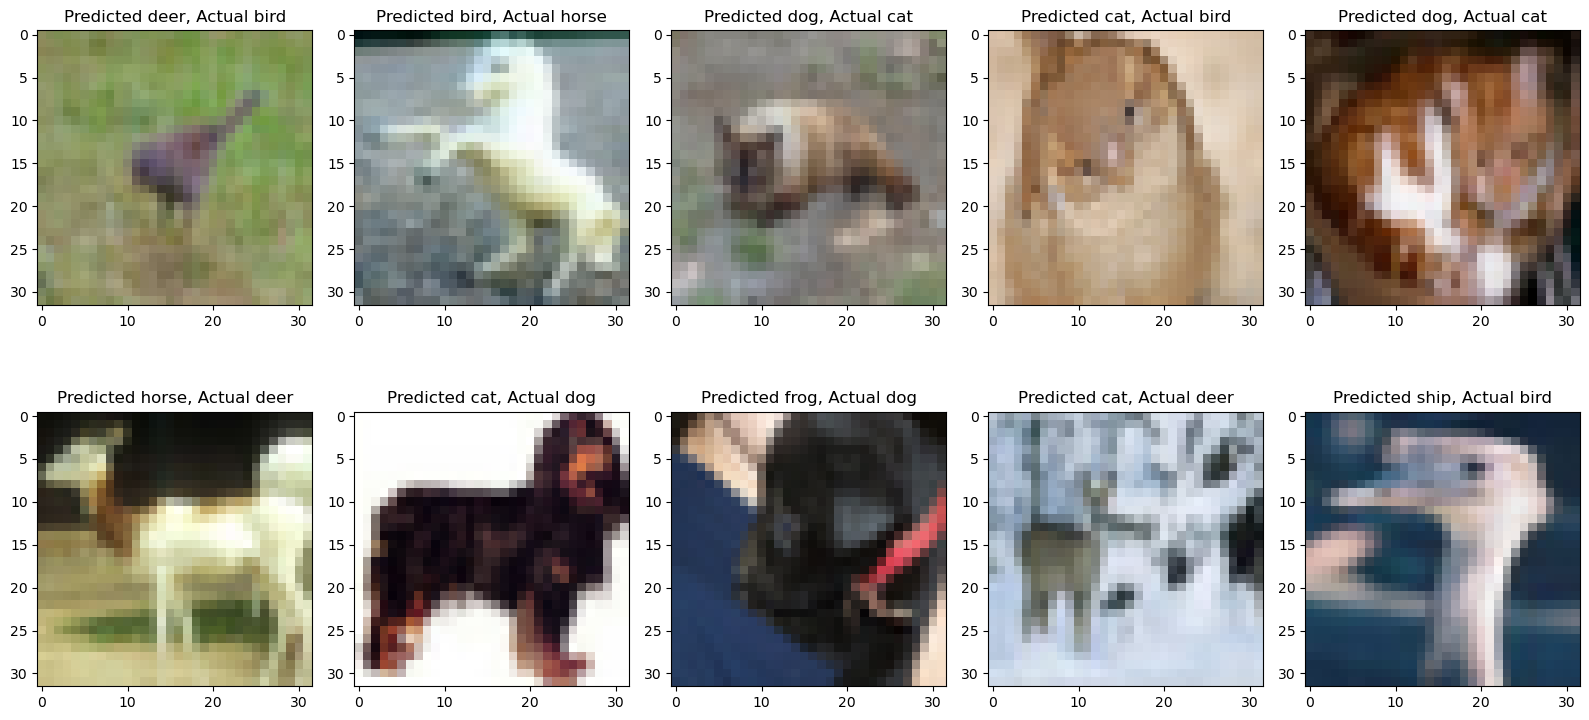

In [10]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()